# Learning Stuff

In [1]:
import os
import numpy as np
import pandas as pd

from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import dextra.dna.core as C
import dextra.dna.text as T
import dextra.dna.commons as P

Using local environment.


In [3]:
spark = P.config.spark

pd.set_option('display.max_colwidth', 200)

sns.set()

## Reading Dataset

In [4]:
DATA_FILE = P.config.lakes.refined + '/issues.encoded.parquet'

x = C.io.stream.read(DATA_FILE)

x.limit(2).toPandas()

,complaint_id,consumer_message,customer_name,date_received,disputed,issue,product,resolution,state,sub_issue,...,via,zip_code,ingested_at,tags_trusted_labels,tags_split,text_cleaned,committed_at,text_cleaned_words,text_cleaned_filtered,features
0,024f01fdf2f6,"After realizing that my rescission rights were still effective due to the fact that my loan has not yet been consummated under the laws of California, I sent Ocwen Loan Servicing , LLC a letter re...",bddd00d386a3,2015-09-09,False,"Loan modification,collection,foreclosure",Mortgage,Closed with explanation,CA,None,...,Web,913XX,2020-12-08 21:22:48.137401,False,test,after realizing that my rescission rights were still effective due to the fact that my loan has not yet been consummated under the laws of california i sent ocwen loan servicing llc a letter resci...,2020-12-08 21:24:36.162162,"[after, realizing, that, my, rescission, rights, were, still, effective, due, to, the, fact, that, my, loan, has, not, yet, been, consummated, under, the, laws, of, california, i, sent, ocwen, loa...","[realizing, rescission, rights, still, effective, due, fact, loan, yet, consummated, laws, california, sent, ocwen, loan, servicing, llc, letter, rescinding, loan, {hash}, {numeric}, letter, maile...","[0.07374545391152812, 0.04484421643174045, -0.0408787455860159, -0.03009743251996191, -9.583036400647478e-05, -0.015900279155453983, -0.046945020017154324, -0.0370292294249791, -0.0025797497151582..."
1,0264246c03dd,Bank of America is not reporting correctly on my credit. They included my mortgage in a Bankruptcy when I had paperwork with in my bankruptcy indicating possible re-affirmation. I continued to mak...,77ba487b3ab6,2015-07-27,True,"Loan servicing, payments, escrow account",Mortgage,Closed with non-monetary relief,UT,None,...,Web,840XX,2020-12-08 21:22:48.137401,False,train,bank of america is not reporting correctly on my credit they included my mortgage in a bankruptcy when i had paperwork with in my bankruptcy indicating possible re affirmation i continued to make ...,2020-12-08 21:24:36.162162,"[bank, of, america, is, not, reporting, correctly, on, my, credit, they, included, my, mortgage, in, a, bankruptcy, when, i, had, paperwork, with, in, my, bankruptcy, indicating, possible, re, aff...","[bank, america, reporting, correctly, credit, included, mortgage, bankruptcy, paperwork, bankruptcy, indicating, possible, re, affirmation, continued, make, payments, time, also, indicating, reaff...","[0.1445439619958767, -0.04791002091569979, 0.048570528399336656, 0.05091682916171238, 0.05213568460379468, -0.054443468702346336, -0.0417751086375783, -0.0070928877799725926, 0.03407933372912593, ..."


## Learning Products

We simulate only a few rows contain trustworthy information in its tags.
For example, we have only been able to verify the accuracy of ~150 samples from the entire set.

We will use `clustering` on top of the learned embedding (word2vec) to figure it out if the average pattern behind these labels is solid.

In [5]:
from pyspark.sql import Window

ws = (Window
       .partitionBy('product')
       .orderBy(F.desc('date_received')))

xs = (x.withColumn('nth', F.row_number().over(ws))
       .where(F.col('nth') < 300))

In [6]:
print('records                    :', x.count())
print('300 most recent/product    :', xs.count())
print('records with trusted labels:', xs.where(xs.tags_trusted_labels).count())

records                    : 199970
300 most recent/product    : 5092
records with trusted labels: 492


### Affinity Through the Cosine Similarity

Spark does not have a cosine implementation:
```
cos(u, v) = (u . v) * (1/||u||) * (1/||v||)
```

However, we can use this neat trick to create it:
```
(a*u) . v = a * (u . v)
=> (u . v) * (1/||u||) * (1/||v||)
=  (u/||u||) . (v/||v||)
```

That is, the cosine similarity is the simple dot product between 
**normal** vectors.

In [7]:
from pyspark.ml.feature import Normalizer

def normalize(x):
    normalizer = Normalizer(inputCol='features', outputCol='features_norm')
    return normalizer.transform(x)

x_ = normalize(xs).select(
    'complaint_id',
    'tags_trusted_labels',
    'features_norm',
    'product'
).toPandas()

x_.head(2)

,complaint_id,tags_trusted_labels,features_norm,product
0,4cfabf259f1f,False,"[-0.009777588147945663, 0.1691317544212158, 0.08335104526459476, -0.05880987402910145, -0.03769638464625495, -0.02032390119227514, -0.1810412422157332, -0.09435662093872214, 0.046502013018689906, ...",Debt collection
1,9f29fe1890ab,False,"[0.013240477885135911, 0.10379844068750262, 0.06653558958797158, -0.08425825358460123, -0.07041193120876418, 0.05467430718757024, -0.0990563804464939, -0.10971603575403172, 0.11628744433222878, -0...",Debt collection


In [28]:
x_.size

25460

From all samples collected, only 15 contain labels that we trust (we manually curated them).

In [8]:
dict(zip(*np.unique(x_.tags_trusted_labels, return_counts=True)))

{False: 4599, True: 493}

In [9]:
from sklearn import metrics

fn = np.asarray([r for r in x_.features_norm])
cs = np.inner(fn, fn)

In [10]:
cs[:5].round(2)

array([[1.  , 0.75, 0.6 , ..., 0.21, 0.09, 0.64],
       [0.75, 1.  , 0.75, ..., 0.23, 0.2 , 0.68],
       [0.6 , 0.75, 1.  , ..., 0.14, 0.3 , 0.7 ],
       [0.63, 0.68, 0.53, ..., 0.17, 0.05, 0.32],
       [0.14, 0.37, 0.21, ..., 0.36, 0.65, 0.47]])

In [11]:
# Take 5 most similar neighbors, removing one-self (last column)
# and accounting for -1 indexing shifting.
nb = cs.argsort(axis=1)[:, -2:-7:-1]
nb_sim = np.asarray([cs[i, nb[i]] for i in range(len(cs))])

In [12]:
nb[:5]

array([[4844,   75,  947, 3745, 4237],
       [4825,  216,  378, 4865,  448],
       [  40,  431,  322, 4604,  612],
       [ 337, 4825, 4394, 2809,   68],
       [ 482, 4681, 5034, 4908, 4268]])

In [13]:
nb_sim[:5].round(2)

array([[0.83, 0.82, 0.81, 0.81, 0.81],
       [0.89, 0.87, 0.85, 0.85, 0.85],
       [0.91, 0.89, 0.88, 0.87, 0.87],
       [0.72, 0.71, 0.7 , 0.69, 0.68],
       [0.88, 0.86, 0.85, 0.85, 0.84]])

#### Infferring Neighbors Based on Affinity

We "contaminate" each non-trusted complaint with
the label of its most similar trusted neighbor.

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

z = TSNE().fit_transform(fn)
y = MiniBatchKMeans().fit_predict(fn)
y = [f'cluster {e}' for e in y]

x_['cluster'] = y

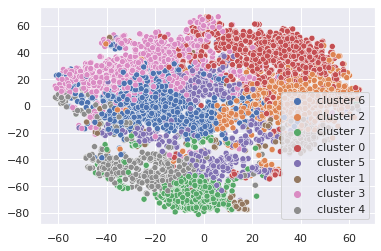

In [15]:
_x, _y = z.T

sns.scatterplot(x=_x, y=_y, hue=y);

In [25]:
ht = (x_[x_.tags_trusted_labels]
      .groupby(['product', 'cluster'], as_index=False)
      .agg({'complaint_id': 'count'})
      .pivot('product', 'cluster', 'complaint_id')
      .fillna(0))

# Transform counts in rates
ht = ht / ht.sum(axis=1).values.reshape(-1, 1)

# Sort from most coherent to most unsure
ht = (ht.assign(max=ht.max(axis=1))  
        .sort_values('max', ascending=False)
        .drop('max', 1))

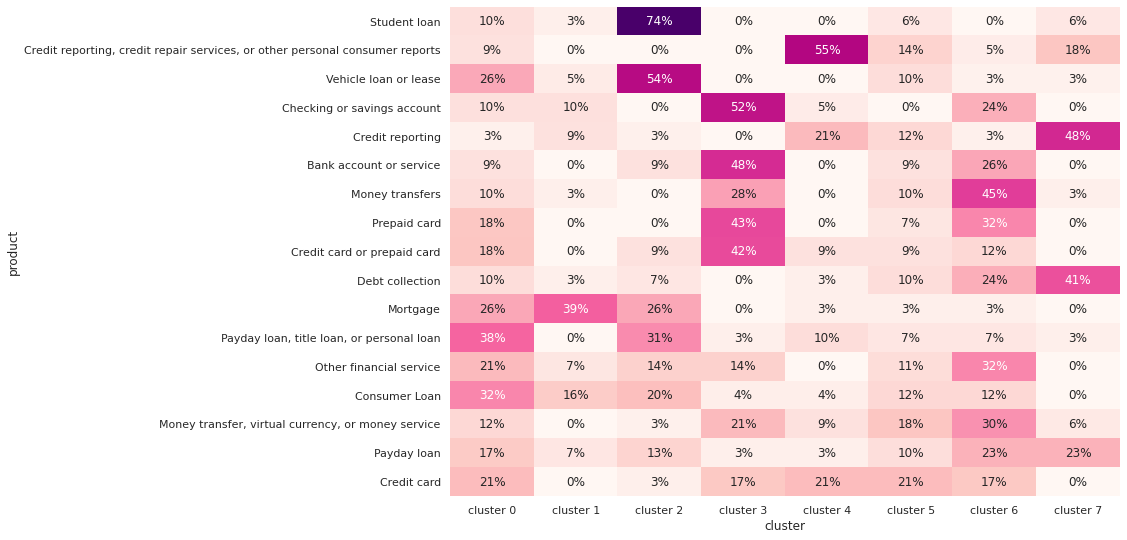

In [26]:
plt.figure(figsize=(12, 9))
ax = sns.heatmap(ht, cmap='RdPu', fmt='.0%', annot=True, cbar=False);